# Generate correct probabilities and use decision theory

In [2]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import norm
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
from utils.probs import *

In [5]:
path = Path('../dataset/')

In [6]:
CHEMBL205 = path/'13321_2017_226_MOESM1_ESM/CHEMBL205'

In [7]:
DATA = path/'probabilities'

In [33]:
df_RF = pd.read_csv(DATA/'RF_probabilityfunction1.csv')

In [34]:
df_RF.head()

,w,p,mu,sigma
0,0.000223,0.000625,3.754835,1.312323
1,0.000222,0.001049,3.706937,1.309473
2,0.000221,0.001267,3.656876,1.332337
3,0.000220,0.000935,3.667281,1.309200
4,0.000219,0.000791,3.712052,1.263111


In [35]:
df_test1 = pd.read_csv(DATA/'modCHEMBL205_predictions_RF.csv')

In [36]:
df_test1.head()

,class,prediction,predicted_class,prediction_int,prediction_lnodds
0,0,0.975,0,195,3.644701
1,0,0.990,0,198,4.547894
2,0,0.950,0,190,2.935226
3,0,0.995,0,199,5.200532
4,1,0.105,1,21,-2.138765


In [37]:
df_output = df_test1.prediction
df_output.head()

0    0.975
1    0.990
2    0.950
3    0.995
4    0.105
Name: prediction, dtype: float64

In [38]:
preds = df_output.to_numpy()

In [39]:
preds

array([0.975, 0.99 , 0.95 , ..., 0.915, 0.99 , 0.3  ])

In [40]:
def RF_direct_prob(x, cl, w, p, m, s):
    """
    Gives probability of class conditional on RF-output
    x = RF output (between 0 and 1)
    cl = class (0 or 1)
    w = array of weights
    p = array of probs
    m = array of means for gaussian
    s = array of standard devs for gaussian
    """
    cl = cl
    c = 1 - 2**-10
    x2 = 0.5 + (x-0.5) * c
    y = np.log(x2/(1-x2))
    pc = p*cl + (1-p) * (1-cl)
    pjoint = np.sum(pc * w * norm.pdf(y, loc=m, scale=s))
    px = np.sum(w * norm.pdf(y, loc=m, scale=s))
    out = pjoint / px
    return out

In [41]:
df = df_RF
mu = df.mu.to_numpy()
sigma = df.sigma.to_numpy()
p = df.p.to_numpy()
w = df.w.to_numpy()

In [42]:
preds

array([0.975, 0.99 , 0.95 , ..., 0.915, 0.99 , 0.3  ])

In [43]:
all_probs_0 = np.array([])
for pred in preds:
    prob = RF_direct_prob(pred, 0, w, p, mu, sigma)
    all_probs_0 = np.append(all_probs_0, prob)
all_probs_0

array([0.99784844, 0.99832858, 0.99593276, ..., 0.98883941, 0.99832858,
       0.11968487])

In [44]:
all_probs_1 = np.array([])
for pred in preds:
    prob = RF_direct_prob(pred, 1, w, p, mu, sigma)
    all_probs_1 = np.append(all_probs_1, prob)
all_probs_1

array([0.00215156, 0.00167142, 0.00406724, ..., 0.01116059, 0.00167142,
       0.88031513])

In [47]:
df_all = pd.DataFrame()
df_all['class'] = df_test1['class'] 
df_all['preds'] = preds
df_all['probs_class_0'] = all_probs_0
df_all['probs_class_1'] = all_probs_1
df_all

,class,preds,probs_class_0,probs_class_1
0,0,0.975,0.997848,0.002152
1,0,0.990,0.998329,0.001671
2,0,0.950,0.995933,0.004067
3,0,0.995,0.998112,0.001888
4,1,0.105,0.092222,0.907778
...,...,...,...,...
3583,1,0.150,0.096281,0.903719
3584,0,0.995,0.998112,0.001888
3585,0,0.915,0.988839,0.011161
3586,0,0.990,0.998329,0.001671


In [48]:
df_all['prediction'] = df_all['probs_class_1'] > 0.5
df_all.prediction = df_all.prediction.to_numpy(dtype=int)
df_all.head()

,class,preds,probs_class_0,probs_class_1,prediction
0,0,0.975,0.997848,0.002152,0
1,0,0.990,0.998329,0.001671,0
2,0,0.950,0.995933,0.004067,0
3,0,0.995,0.998112,0.001888,0
4,1,0.105,0.092222,0.907778,1


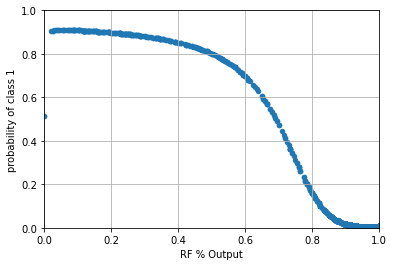

In [49]:
df_all.plot.scatter(x='preds', y='probs_class_1')
plt.xlabel('RF % Output')
plt.ylabel('probability of class 1')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()


#plt.savefig('../dataset/RF_output.png')
plt.show()

## Confusion matrix for original predictions

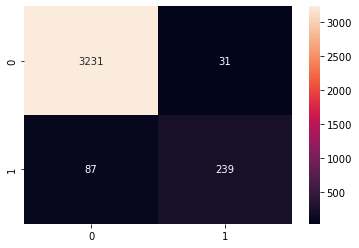

In [51]:
y = df_all['class'].to_numpy()
y_pred = df_test1.predicted_class.to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Confusion matrix for corrected predictions

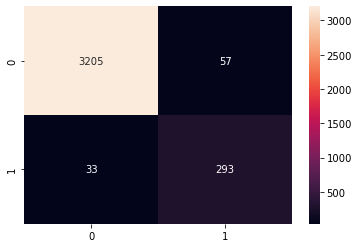

In [52]:
y = df_all['class'].to_numpy()
y_pred = df_all.prediction.to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [53]:
df_all.to_csv(DATA/'RF_direct_prob_test1.csv')

### same for test set 2

In [58]:
df_test2 = pd.read_csv(DATA/'CHEMBL205_predictions_RF_test2.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/probabilities/CHEMBL205_predictions_RF_test2.csv'

# Decision theory

### Test an example with gains/losses

In [54]:
''' 
Utility matrix format: 
    [[TN, FP],
     [FN, TP]]
'''
M = np.array([[15,-80],
              [-1,0]], dtype=float)
#M /= np.abs(M).max()
M = torch.from_numpy(M)
M = M.to(torch.float64)
M

tensor([[ 15., -80.],
        [ -1.,   0.]], dtype=torch.float64)

In [55]:
test1 = np.array([[0.18, 0.02], [0.32, 0.48]], dtype=np.float64)
test2 = np.array([[0.16, 0.04], [0.08, 0.72]], dtype=np.float64)

In [56]:
res1 = M * test1
res2 = M * test2

In [57]:
sum1, sum2 = res1.sum(), res2.sum()
print('Gains from algorithms:')
print(f'#1 {sum1:.2f}, #2 {sum2:.2f}')

Gains from algorithms:
#1 0.78, #2 -0.88


### Create a function for a utility matrix with cost for each case (TN, FP, FN, TP)

In [154]:
utility = np.array([[10, -1], [-10, 1]], dtype=np.float64)

In [139]:
def get_expected_cost (um, m):
    if um.max() > 1:
        if m.max() > 1:
            um /= np.abs(um).max()
    s = um * m
    s1 = s[0].sum()
    s2 = s[1].sum()
    return [s1, s2]

In [7]:
def get_expected_cost (um, m):
    m = np.array(m)
    if um.max() > 1:
        if m.max() > 1:
            um /= np.abs(um).max()
    s1 = um[0] * m
    s2 = um[1] * m
    s1 = s1.sum()
    s2 = s2.sum()
    return [s1, s2]

In [122]:
cm = confusion_matrix(y, y_pred)
cm

array([[3231,   31],
       [  87,  239]])

In [146]:
cost = get_cost(utility, cm[1])
cost

326.0

In [141]:
c = get_expected_cost(utility, cm)
c

[3231.0, 239.0]

In [163]:
df_all['probs'] = [[r['probs_class_0'], r['probs_class_1']] for i, r in df_all.iterrows()]
df_all.head()

,class,preds,probs_class_0,probs_class_1,prediction,probs
0,0,0.975,0.997848,0.002152,0,"[0.9978484371013459, 0.002151562898654075]"
1,0,0.990,0.998329,0.001671,0,"[0.998328584124416, 0.0016714158755837688]"
2,0,0.950,0.995933,0.004067,0,"[0.9959327602479192, 0.004067239752081032]"
3,0,0.995,0.998112,0.001888,0,"[0.9981116284172469, 0.0018883715827530312]"
4,1,0.105,0.092222,0.907778,1,"[0.09222187670619506, 0.9077781232938047]"


In [169]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
utility = np.array([[1, -1], 
                    [-1, 1]], dtype=np.float64)

In [170]:
def get_expected_utility (um, m):
    m = np.array(m)
    if um.max() > 1:
        if m.max() > 1:
            um /= np.abs(um).max()
    s1 = um[0] * m
    s2 = um[1] * m
    s1 = s1.sum()
    s2 = s2.sum()
    return [s1, s2]

In [171]:
df_all['expected_utility'] = [get_expected_utility(utility, r['probs']) for i, r in df_all.iterrows()]
df_all['best_utility_class'] = torch.tensor(df_all['expected_utility']).argmax(axis=1)
df_utility = df_all.drop(columns= ['prediction', 'preds'])
df_utility.head()

,class,probs_class_0,probs_class_1,probs,expected_utility,best_utility_class
0,0,0.997848,0.002152,"[0.9978484371013459, 0.002151562898654075]","[0.9956968742026918, -0.9956968742026918]",0
1,0,0.998329,0.001671,"[0.998328584124416, 0.0016714158755837688]","[0.9966571682488323, -0.9966571682488323]",0
2,0,0.995933,0.004067,"[0.9959327602479192, 0.004067239752081032]","[0.9918655204958382, -0.9918655204958382]",0
3,0,0.998112,0.001888,"[0.9981116284172469, 0.0018883715827530312]","[0.9962232568344939, -0.9962232568344939]",0
4,1,0.092222,0.907778,"[0.09222187670619506, 0.9077781232938047]","[-0.8155562465876096, 0.8155562465876096]",1


In [ ]:
df_utility.to_csv(DATA/'RF_direct_prob_utility.csv')

# Generate correct probabilities for CNN model for test1 and test2

In [9]:
df_CNN = pd.read_csv(DATA/'CNN_probabilityfunction_full.csv')
df_CNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262142 entries, 0 to 262141
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   w       262142 non-null  float64
 1   p       262142 non-null  float64
 2   mu0     262142 non-null  float64
 3   sigma0  262142 non-null  float64
 4   mu1     262142 non-null  float64
 5   sigma1  262142 non-null  float64
dtypes: float64(6)
memory usage: 12.0 MB


In [10]:
df_CNN.head()

,w,p,mu0,sigma0,mu1,sigma1
0,1.112547e-308,0.174027,2.249256,5.060917,-2.448301,0.254581
1,2.021356e-302,0.465301,1.497763,0.403940,-4.069391,0.219020
2,2.451473e-297,0.478021,2.776968,2.754942,-1.012342,0.758008
3,1.542531e-295,0.992075,3.959678,0.091651,-0.177518,0.689752
4,2.402227e-289,0.332206,2.568715,0.593366,-0.892260,0.143567


In [13]:
#function for making a list of strings in df to list of floats
def get_substring_list(split):
    if len(split) <= 1:
        print('nooo')
    i = 0
    while len(split[i]) <= 1:
        i += 1
    s1 = split[i]
    i += 1
    while len(split[i]) <= 1:
        i += 1
    s2 = split[i]
    if s1[0] == '[':
        s1 = s1[1:]
    if s2[-1] == ']':
        s2 = s2[0:-1]
    s1 = np.float64(s1)
    s2 = np.float64(s2)
    return [s1, s2]

### Test1

In [12]:
df_test1 = pd.read_csv(CHEMBL205/'CHEMBL205_predictions_CNN_test1.csv')
df_test1['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test1.iterrows()]
#df_preds['pred_0'] = np.array(df_preds['pred_0'], dtype=np.float64)
df_test1.head()

,class,predictions,predicted_class,preds
0,0,[1.0686324 0.15983486],1.068632,"[1.0686324, 0.15983486]"
1,0,[ 3.294977 -3.2591858],3.294977,"[3.294977, -3.2591858]"
2,0,[ 3.8328545 -3.5713747],3.832854,"[3.8328545, -3.5713747]"
3,0,[ 3.13148 -3.6825964],3.131480,"[3.13148, -3.6825964]"
4,1,[-0.78947127 1.3680041 ],1.368004,"[-0.78947127, 1.3680041]"


In [14]:
def calculate_probs_CNN(df, df_preds):
    preds = df_preds['preds']
    m0 = df.mu0.to_numpy()
    s0 = df.sigma0.to_numpy()
    m1 = df.mu1.to_numpy()
    s1 = df.sigma1.to_numpy()
    p = df.p.to_numpy()
    w = df.w.to_numpy()
    all_probs_0 = np.array([])
    for pred in preds:
        prob = CNN_direct_prob(pred, 0, w, p, m0, s0, m1, s1)
        all_probs_0 = np.append(all_probs_0, prob)
    return all_probs_0

In [16]:
arr = calculate_probs_CNN(df_CNN, df_test1)
arr

array([0.81222591, 0.99782956, 0.99589563, ..., 0.99853791, 0.83105265,
       0.98928451])

In [17]:
len(arr)

3589

In [18]:
type(arr)

numpy.ndarray

In [20]:
df_test1['predictions'] = df_test1['preds']
df_test1['direct_prob_0'] = arr
df_test1 = df_test1.drop(columns=['preds', 'predicted_class'])

In [21]:
df_test1.head()

,class,predictions,direct_prob_0
0,0,"[1.0686324, 0.15983486]",0.812226
1,0,"[3.294977, -3.2591858]",0.997830
2,0,"[3.8328545, -3.5713747]",0.995896
3,0,"[3.13148, -3.6825964]",0.997027
4,1,"[-0.78947127, 1.3680041]",0.230960


In [32]:
df_test1.to_csv(DATA/'CNN_bayesian_prob_test1.csv')

### Do the same for test set 2

In [23]:
df_test2 = pd.read_csv(CHEMBL205/'CHEMBL205_predictions_CNN_test2.csv')
df_test2['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test2.iterrows()]
#df_preds['pred_0'] = np.array(df_preds['pred_0'], dtype=np.float64)
df_test2.head()

,class,predictions,predicted_class,preds
0,0,[1.0686324 0.15983486],1.068632,"[1.0686324, 0.15983486]"
1,0,[ 3.294977 -3.2591858],3.294977,"[3.294977, -3.2591858]"
2,0,[ 3.8328545 -3.5713747],3.832854,"[3.8328545, -3.5713747]"
3,0,[ 3.13148 -3.6825964],3.131480,"[3.13148, -3.6825964]"
4,1,[-0.78947127 1.3680041 ],1.368004,"[-0.78947127, 1.3680041]"


In [26]:
probs = calculate_probs_CNN(df_CNN, df_test2)

In [29]:
df_test2['predictions'] = df_test2['preds']
df_test2['direct_prob_0'] = probs
df_test2 = df_test2.drop(columns=['preds', 'predicted_class'])

In [31]:
df_test2.to_csv(DATA/'CNN_bayesian_prob_test2.csv')

## Test for utility matrix

In [136]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
utility = np.array([[1, 0], 
                    [0, 1]], dtype=np.float64)

In [138]:
df = df_preds
df['expected_utility'] = [get_expected_utility(utility, [r['direct_prob_0'], 1 - r['direct_prob_0']]) 
                          for i, r in df.iterrows()]
df['best_utility_class'] = torch.tensor(df['expected_utility']).argmax(axis=1)

In [139]:
df.head()

,class,predictions,predicted_class,direct_prob_0,expected_utility,best_utility_class
0,0,"[1.0686345, 0.15982893]",0,0.812227,"[0.8122267607382875, 0.18777323926171252]",0
1,0,"[3.294972, -3.2591784]",0,0.997830,"[0.997829581810393, 0.0021704181896069485]",0
2,0,"[3.8328488, -3.5713756]",0,0.995896,"[0.9958956353188672, 0.004104364681132844]",0
3,0,"[3.1314778, -3.682592]",0,0.997027,"[0.9970271557275053, 0.002972844272494668]",0
4,1,"[-0.789468, 1.3680037]",1,0.230961,"[0.2309608425386519, 0.7690391574613481]",1


,class,direct_prob_0,prediction_0
0,0,0.812227,1.068634
1,0,0.997830,3.294972
2,0,0.995896,3.832849
3,0,0.997027,3.131478
4,1,0.230961,-0.789468


In [189]:
df_save = df_preds
df_save.to_csv(DATA/'CNN_direct_prob.csv')